<a href="https://colab.research.google.com/github/Chygos/competitions/blob/main/nfts/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm catboost xgboost scikit-learn --upgrade --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 55.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# changing directory
import os
os.chdir("./gdrive/My Drive/bitgrid competitions/NFT_price_prediction/")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
import catboost as cat
import lightgbm as lgb
import sklearn

In [ ]:
xgb.__version__, lgb.__version__, cat.__version__, sklearn.__version__

('1.7.3', '3.3.4', '1.1.1', '1.2.0')

In [ ]:
pd.set_option('display.max_columns', 70)

In [ ]:
train = pd.read_parquet('data/train_cleaned.parquet')
test = pd.read_parquet('data/test_cleaned.parquet')

In [ ]:
train.head()

,global_index,nft_id,collection_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,openrarity_enabled,has_discord,has_medium,age,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,min_replies,min_retweets,max_likes,max_replies,max_retweets,col_age_at_sale,sale_month,sale_quarter,sale_year,coll_targ_min,coll_targ_mean,coll_targ_max,coll_targ_std,n_nft_in_sdate,col_min_last_sale_price,col_mean_last_sale_price,col_max_last_sale_price,col_std_last_sale_price,c_labels_1,c_labels_2,c_labels_3,targ_proba
0,21928,0,49,2.000000,NaN,NaN,NaN,2022-11-01,1.266732,1,2022-04-01,1,2,1,1000.0,0,1,0,9.002238,31,187.967742,8.290323,60.935484,0,0,2,591,28,380,7.030945,11,4,2022,1.266732,1.266732,1.266732,NaN,1,1.266732,1.266732,1.266732,NaN,1,0,0,0.968786
1,32621,0,45,97.077216,NaN,NaN,NaN,2021-08-01,1.200357,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1.018501,8,3,2021,0.000037,2.559610,400.001379,5.344588,3143,0.000182,2.662060,130.005079,4.641399,1,0,0,0.982246
2,32622,1,45,139.453086,NaN,NaN,NaN,2022-08-01,3.180572,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,13.010534,8,3,2022,0.000037,2.559610,400.001379,5.344588,750,0.000064,4.059408,400.001379,14.646178,1,0,0,0.987769
3,32623,2,45,127.753445,NaN,NaN,NaN,2021-08-01,3.502910,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,1.018501,8,3,2021,0.000037,2.559610,400.001379,5.344588,3143,0.000182,2.662060,130.005079,4.641399,1,0,0,0.978075
4,32624,3,45,112.315719,NaN,NaN,NaN,2022-09-01,4.009567,8888,2021-07-01,1,5,1,500.0,0,1,0,18.004476,11,133.181818,13.454545,55.181818,0,0,7,402,47,239,14.029036,9,3,2022,0.000037,2.559610,400.001379,5.344588,276,0.000441,3.782424,24.005621,1.869985,1,0,0,0.971822


In [ ]:
train.dtypes

global_index                         int64
nft_id                               int64
collection_id                        int64
rarity_score                       float64
openrarity_score                   float64
openrarity_rank                    float64
openrarity_max_rank                float64
last_sale_date              datetime64[ns]
last_sale_price                    float64
total_supply                         int64
creation_date               datetime64[ns]
verification_status                  int64
n_of_traits                          int64
contract_type                        int64
seller_fees                        float64
openrarity_enabled                   int64
has_discord                          int64
has_medium                           int64
age                                float64
n_tweets_in_range                    int64
avg_likes                          float64
avg_replies                        float64
avg_retweets                       float64
min_likes  

In [ ]:
train[['c_labels_1', 'c_labels_2', 'c_labels_3']] = train.filter(like='c_la').astype(int)
test[['c_labels_1', 'c_labels_2', 'c_labels_3']] = test.filter(like='c_la').astype(int)

In [ ]:
test_ids = test.global_index.tolist()

In [ ]:
def scorer(ytrue, ypred):
  rmse = mean_squared_error(ytrue, ypred, squared=False)
  rmse_norm = np.exp(-rmse/10)
  return rmse_norm

rmse_norm = make_scorer(scorer, greater_is_better=False)

In [ ]:
TARGET = 'last_sale_price'

In [ ]:
DROP_COLS = ['last_sale_date', 'creation_date', 'collection_id', 'nft_id', 'global_index']

In [ ]:
tweet_cols = train.filter(regex='likes|tweets|replies').columns.tolist()
collection_cols = train.filter(like='col').columns.tolist()[1:]

In [ ]:
# reshuffles train
train = train.sample(frac=1, random_state=40)

In [ ]:
X = train.drop([TARGET]+DROP_COLS, axis=1)[]
y = np.sqrt(train[TARGET])

In [ ]:
SEED = 42

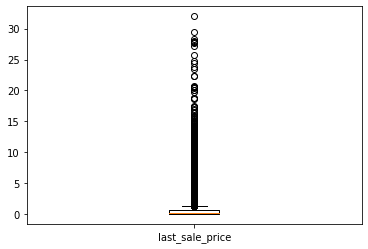

In [ ]:
plt.boxplot(y, labels=[TARGET]);

In [ ]:
# splitting data into 3: train, validation, and pseudo_test datasets
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.25, random_state=SEED)

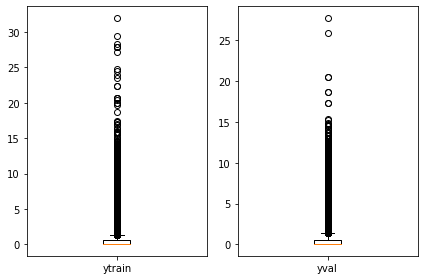

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(6,4))
ax[0].boxplot(ytrain, labels=['ytrain'])
ax[1].boxplot(yval, labels=['yval'])
plt.tight_layout();

In [ ]:
xtest = test.drop(DROP_COLS, axis=1)

In [ ]:
xtrain.shape, xval.shape, xtest.shape

((232432, 40), (77478, 40), (181214, 40))

In [ ]:
def train_model(reg):
  reg.fit(xtrain, ytrain)

def eval_metric(reg, x, y):
  ypreds = np.square(reg.predict(x))
  rmse = mean_squared_error(np.square(y), ypreds, squared=False)
  mae = mean_absolute_error(np.square(y), ypreds)
  rmse_norm = np.exp(-rmse/10)
  print(f'RMSE_NORM: {rmse_norm:.4f}\tRMSE: {rmse:.4f}\tMAE: {mae:.4f}')

### Instantiating Models

In [ ]:
xgbm = xgb.XGBRegressor(n_estimators=5000, colsample_bytree=0.3, subsample=0.8, n_jobs=-1, max_depth=7, 
                        reg_lambda=1, gamma=1, tree_method='hist', random_state=SEED, 
                        learning_rate=0.008, importance_type='weight') #hist

lgbm = lgb.LGBMRegressor(n_estimators=5000, colsample_bytree=0.3, subsample=0.8, importance_type='gain',
                         reg_lambda=1, random_state=SEED, learning_rate=0.008, max_depth=7, 
                         num_leaves=35, min_child_samples=10)

catm = cat.CatBoostRegressor(n_estimators=5000, task_type='CPU', devices='0:3', silent=True,bootstrap_type='Bernoulli',
                             random_state=SEED, subsample=0.8, learning_rate=0.01, max_depth=8, 
                             l2_leaf_reg=1, colsample_bylevel=0.3, grow_policy='Depthwise')

## Training Model

In [ ]:
def feature_importance(reg, top_n=10):
  imp = pd.Series(reg.feature_importances_, index=xtrain.columns).sort_values()
  imp = imp/imp.sum()
  imp[-top_n:].plot.barh(figsize=(9,6))

__XGBoost__

In [ ]:
train_model(xgbm)

In [ ]:
eval_metric(xgbm, xtrain, ytrain)

RMSE_NORM: 0.5496	RMSE: 5.9855	MAE: 1.0163


In [ ]:
eval_metric(xgbm, xval, yval)

RMSE_NORM: 0.4638	RMSE: 7.6841	MAE: 1.1805


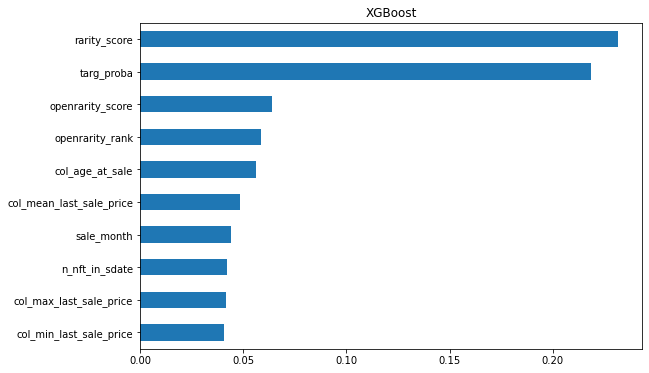

In [ ]:
feature_importance(xgbm)
plt.title('XGBoost');

__LightGBM__

In [ ]:
train_model(lgbm)

In [ ]:
eval_metric(lgbm, xtrain, ytrain)

RMSE_NORM: 0.5106	RMSE: 6.7226	MAE: 1.0702


In [ ]:
eval_metric(lgbm, xval, yval)

RMSE_NORM: 0.4771	RMSE: 7.3999	MAE: 1.1559


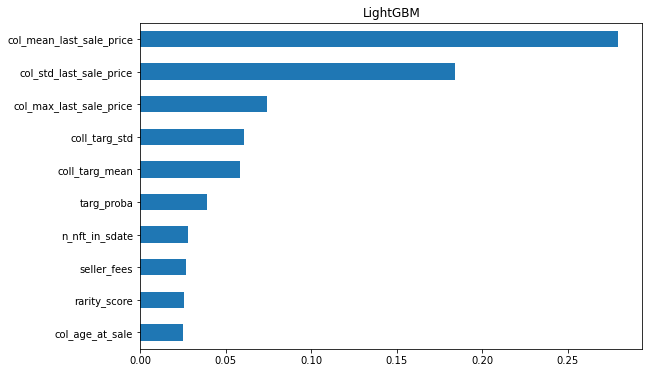

In [ ]:
feature_importance(lgbm)
plt.title('LightGBM');

__CatBoost__

In [ ]:
train_model(catm)

In [ ]:
eval_metric(catm, xtrain, ytrain)

RMSE_NORM: 0.5748	RMSE: 5.5375	MAE: 0.9581


In [ ]:
eval_metric(catm, xval, yval)

RMSE_NORM: 0.4509	RMSE: 7.9649	MAE: 1.1937


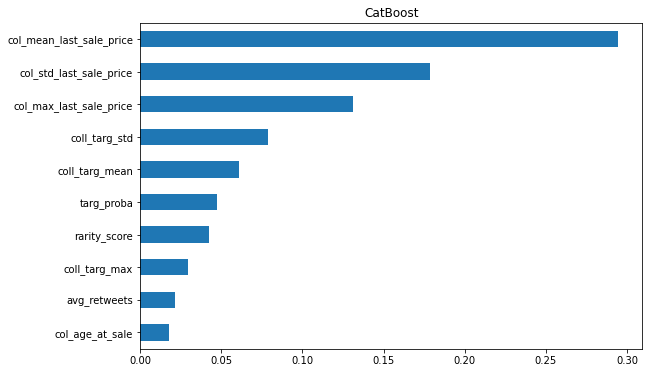

In [ ]:
feature_importance(catm)
plt.title('CatBoost');

# Evaluating on held-out test set

In [ ]:
# eval_metric(xgbm, xtest1, ytest1)

RMSE_NORM: 0.4268	RMSE: 8.5149	MAE: 1.2112


In [ ]:
# eval_metric(lgbm, xtest1, ytest1)

RMSE_NORM: 0.4414	RMSE: 8.1791	MAE: 1.1895


In [ ]:
# eval_metric(catm, xtest1, ytest1)

RMSE_NORM: 0.4445	RMSE: 8.1091	MAE: 1.1694


## Fitting on all data and predicting on test set

In [ ]:
xgbm.fit(X, y);

In [ ]:
lgbm.fit(X, y);

In [ ]:
catm.fit(X, y);

# Predictions

In [ ]:
def predict(reg, x):
  preds = np.square(reg.predict(x))
  return preds

In [ ]:
xgb_preds = predict(xgbm, xtest)
lgb_preds = predict(lgbm, xtest)
cat_preds = predict(catm, xtest)

In [ ]:
#!mkdir preds

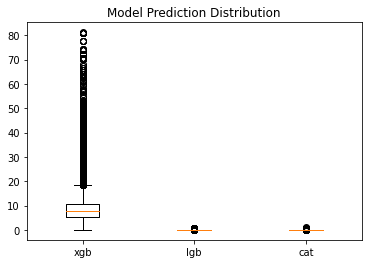

In [ ]:
plt.boxplot(np.c_[xgb_preds, lgb_preds, cat_preds], labels=['xgb', 'lgb', 'cat'])
plt.title('Model Prediction Distribution')
plt.show()

In [ ]:
def save_file(preds, name=None):
  df = pd.DataFrame(np.c_[test_ids, preds], columns=['global_index', TARGET])
  df.global_index = df.global_index.astype(int)
  df.to_csv(f'preds/{name}.csv', index=False)

In [ ]:
save_file(xgb_preds, 'xgb_1')
save_file(lgb_preds, 'lgb_1')
save_file(cat_preds, 'cat_1')